# Исследование исходных данных
### Исследование аудиофайлов

In [2]:
import os
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa
import torchaudio.transforms as T
from torch_audiomentations import Compose, PitchShift

In [3]:
def show_random_audio(dataset_path="V:/dataset/music"):
    cleaned_dataset_name = "dataset_all_moods.tsv"
    cleaned_dataset_path = os.path.join(dataset_path, cleaned_dataset_name)

    if not os.path.isfile(os.path.join(dataset_path, cleaned_dataset_path)):
        print(f"This script requires the {cleaned_dataset_name} file to be present. Please, run 'scriprs.preprocess_dataset.py --path <dataset_path>' first.")
        return

    dataset = pd.read_csv(cleaned_dataset_path, sep="\t")

    # Show random audio amplitudes and spectrograms.
    random_row = dataset.sample(n=1)
    random_song_path = os.path.abspath(os.path.join(dataset_path, random_row.iloc[0]["path"]))
    random_spec_path = os.path.abspath(os.path.join(dataset_path, random_row.iloc[0]["melspecs_path"]))
    print(f"Random song selected:\n{random_song_path}\n")

    if not os.path.isfile(random_song_path):
        print(f"File {random_song_path} not found. Please, ensure that you have the dataset and the path is correct.")
        return

    amplitudes, sample_rate = librosa.core.load(random_song_path)
    print(f"Audio length: {amplitudes.shape[0] / sample_rate:.3f} seconds at sample rate {sample_rate}")
    print(f"Samples number {amplitudes.shape[0]}\n")

    # Generate a spectrogram using Short-Time Fourier Transform (STFT)
    window_length = 2048
    hop_length = 512
    window_time = window_length / sample_rate

    spectrogram = librosa.stft(amplitudes, n_fft=window_length, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    print(f"STFT-built spectrogram shape: {spectrogram_db.shape}")

    # Load Mel spectrogram
    mel_spec = np.load(random_spec_path)
    print(f"Dataset mel-spectrogram shape: {mel_spec.shape}")

    show_audio_time = 10  # demo seconds
    show_samples_number = show_audio_time * sample_rate
    show_windows_number = int(show_audio_time / window_time)

    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 1, 1]})
    ax1.set_title(f"First {show_audio_time} seconds of the audio")
    ax1.plot(amplitudes[:show_samples_number])
    ax1.set_xlabel("Samples")
    ax1.set_ylabel("Amplitude")

    ax2.set_title(f"Spectrogram ({show_audio_time}s)")
    ax2.imshow(spectrogram_db[:, :show_windows_number], aspect='auto', origin='lower', cmap='plasma', extent=[0, show_windows_number, 0, spectrogram_db.shape[0]])
    ax2.set_xlabel("Window")
    ax2.set_ylabel("Frequency (Hz)")
    
    ax3.set_title(f"Mel-Spectrogram ({show_audio_time}s)")
    ax3.imshow(mel_spec[:, :show_windows_number], aspect='auto', origin='lower', cmap='plasma', extent=[0, show_windows_number, 0, mel_spec.shape[0]])
    ax3.set_xlabel("Window")
    ax3.set_ylabel("Mel frequency")

    plt.tight_layout()
    plt.show()

    return amplitudes, spectrogram_db, mel_spec, sample_rate

**Исходные данные представляют собой сырые аудиофайлы. Из них возможно извлечение различных характеристик**
В работе на вход модели подаются:
- необработанный звуковой сигнал
- мел-спектрограммы
- числовые характеристики аудио

Random song selected:
V:\dataset\music\94\1420494.mp3

Audio length: 143.741 seconds at sample rate 22050
Samples number 3169483

STFT-built spectrogram shape: (1025, 6191)
Dataset mel-spectrogram shape: (96, 6739)


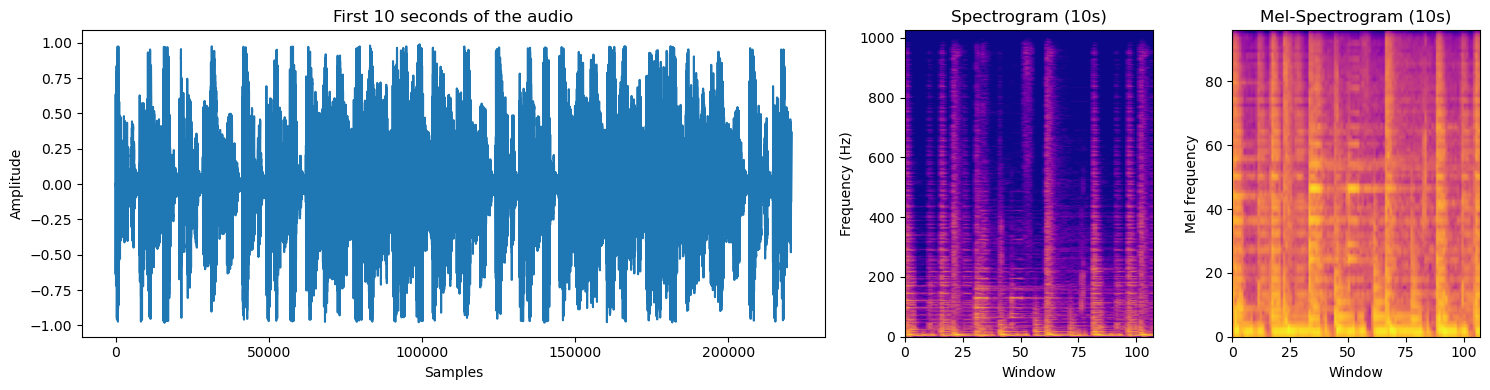

In [4]:
waveform, spec, mel_spec, sample_rate = show_random_audio()

### Аугментация мел-спектрограмм
Для аугментации мел-спектрограмм используются следующие операции:
- маскирование случайного спектра частот. В работе устанавливаются в минимальный уровень сигнала в -90 дБ 6 мел-делений;
- маскирование случайного временного отрезка. В работе маскируются 64 временных деления (окна);
- случайное усиление или ослабление сигнала. К спектрограмме добавляется случайное число в промежутке от -5 до +5;
- применение случайного шума. К спектрограмме добавляется шум согласно равномерному распределению с математическим ожиданием 0 и стандартным отклонением 0,4.

В цикле обучения все аугментации, кроме наложения шума, выполняются с заданной вероятностью (обычно, p=0,3).

In [5]:
def augment_spec(spec, freq_mask_param=6, time_mask_param=64, mask_value=-90.):
        freq_mask = T.FrequencyMasking(freq_mask_param)
        time_mask = T.TimeMasking(time_mask_param)

        # Rundom Gaussian noise (in train cycle with probability).
        noise = np.random.normal(0., 0.2, spec.shape)
        spec += noise

        # Gain in db (in train cycle with probability).
        gain = np.random.uniform(low=-5, high=5)
        spec += gain

        spec_tensor = torch.from_numpy(spec).float()

        # Apply frequency masking (in train cycle with probability).
        spec_tensor = freq_mask(spec_tensor, mask_value=mask_value)
        
        # Apply time masking (in train cycle with probability).
        spec_tensor = time_mask(spec_tensor, mask_value=mask_value)
        
        return spec_tensor.numpy()

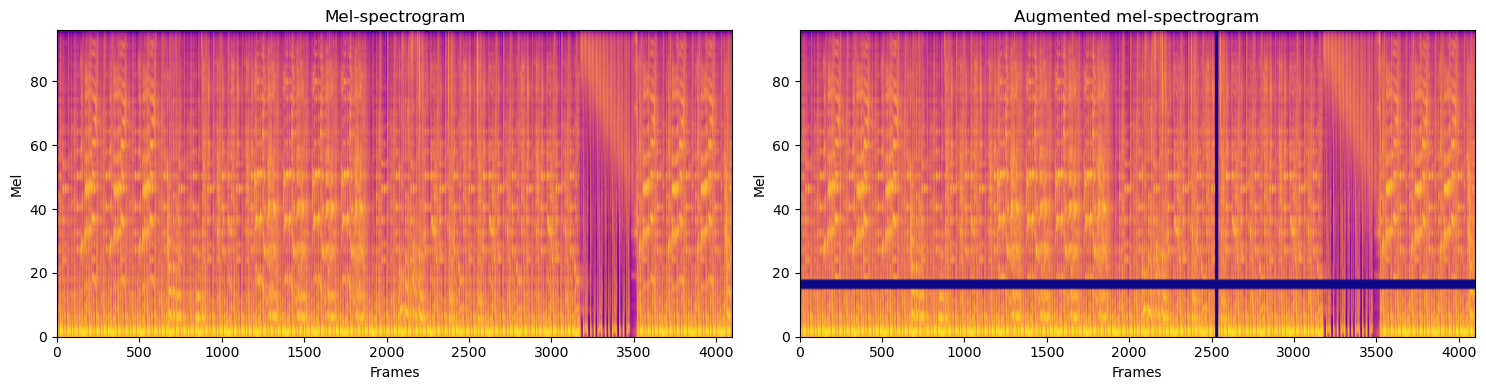

In [6]:
MAX_SPEC_LEN = 4096
mel_spec = mel_spec[:, :MAX_SPEC_LEN]

augmented_spec = augment_spec(mel_spec)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.set_title(f"Mel-spectrogram")
ax1.imshow(mel_spec, aspect='auto', origin='lower', cmap='plasma', extent=[0, mel_spec.shape[1], 0, mel_spec.shape[0]])
ax1.set_xlabel("Frames")
ax1.set_ylabel("Mel")
ax2.set_title(f"Augmented mel-spectrogram")
ax2.imshow(augmented_spec, aspect='auto', origin='lower', cmap='plasma', extent=[0, augmented_spec.shape[1], 0, augmented_spec.shape[0]])
ax2.set_xlabel("Frames")
ax2.set_ylabel("Mel")

plt.tight_layout()
plt.show()

### Аугментация звукового сигнала
Для аугментации сигнала используются следующие операции:
- случайное затухание сигнала длинной в 10% аудио;
- случайный сдвиг аудио на 4 полутона вниз или вверх;
- случайное усиление сигнала в [0,6; 1,1] раз;
- применение случайного шума с максимальной амплитудой в 0,001.

В цикле обучения все аугментации, кроме наложения шума, выполняются с заданной вероятностью (обычно, p=0,3).

In [7]:
def waveform_augment(waveform, sample_rate):
    waveform = torch.from_numpy(waveform).float()
    waveform = waveform.unsqueeze(0).unsqueeze(0)
    fade = T.Fade(fade_in_len=int(0.1 * sample_rate), fade_out_len=int(0.1 * sample_rate))  # 10% fade in/out

    augment = Compose(
        transforms=[
            PitchShift(min_transpose_semitones=-4, max_transpose_semitones=4, p=1, sample_rate=sample_rate, output_type='tensor'),
        ],
        output_type='tensor'
    )

    # Random gain factor between 0.6 and 1.1
    gain_factor = torch.empty(1).uniform_(0.6, 1.1).item()
    vol = T.Vol(gain_factor, gain_type="amplitude")
    waveform = vol(waveform)

    # Random effects
    augment(waveform, sample_rate=sample_rate)

    # Gaussian noise
    max_amp = 0.001
    random_noise_amp = torch.randn(1).item() * max_amp
    noise = torch.randn_like(waveform) * random_noise_amp
    waveform += noise

    # Fade in/out
    waveform = fade(waveform)
    
    waveform = waveform.squeeze(0).squeeze(0)

    return waveform.numpy()

Text(0, 0.5, 'Amplitude')

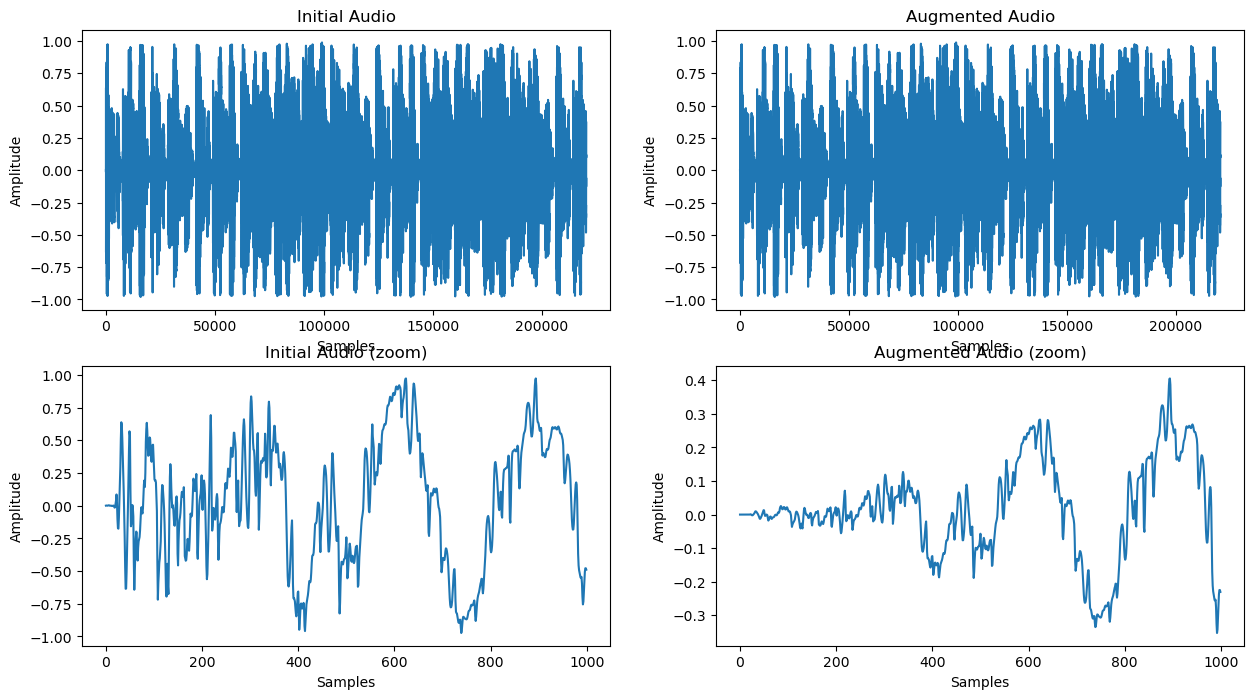

In [8]:
MAX_AUDIO_LEN = 220500
ZOOMED_AUDIO_LEN = 1000
waveform = waveform[:MAX_AUDIO_LEN]

augmented_waveform = waveform_augment(waveform, sample_rate)

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
ax1.set_title(f"Initial Audio")
ax1.plot(waveform)
ax1.set_xlabel("Samples")
ax1.set_ylabel("Amplitude")

ax2.set_title(f"Augmented Audio")
ax2.plot(waveform)
ax2.set_xlabel("Samples")
ax2.set_ylabel("Amplitude")

ax3.set_title(f"Initial Audio (zoom)")
ax3.plot(waveform[:ZOOMED_AUDIO_LEN])
ax3.set_xlabel("Samples")
ax3.set_ylabel("Amplitude")

ax4.set_title(f"Augmented Audio (zoom)")
ax4.plot(augmented_waveform[:ZOOMED_AUDIO_LEN])
ax4.set_xlabel("Samples")
ax4.set_ylabel("Amplitude")

### Исследование характеристик аудио

In [9]:
def load_features(dataset_path="V:/dataset/music", dataset_name="features_dataset_all_moods.tsv"):
    df = pd.read_csv(os.path.join(dataset_path, dataset_name), sep="\t")
    return df

In [10]:
df = load_features()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18486 entries, 0 to 18485
Columns: 180 entries, zcr_mean to tags
dtypes: float64(177), int64(1), object(2)
memory usage: 25.4+ MB


Из исходных аудиофайлов были извлечены характеристики. Некоторые из них являются изменяющимися во времени, поэтому такие характеристики усреднялись, вычислялись их стандартное отклонение, процентили, степень ассиметрии и эксцесс. Полученные статистики могут быть полезными при применении многослойных перцептронов, так как самостоятельно MLP не имеет возможности их вычисления.

In [11]:
stats_terms = ["std", "kurtosis", "skew", "p25", "p50", "p75"]
initial_columns = [col for col in df.columns if not any(term in col for term in stats_terms)]
initial_columns

['zcr_mean',
 'rmse_mean',
 'centroid_mean',
 'bandwidth_mean',
 'rolloff_mean',
 'flatness_mean',
 'flux_mean',
 'chroma1_mean',
 'chroma2_mean',
 'chroma3_mean',
 'chroma4_mean',
 'chroma5_mean',
 'chroma6_mean',
 'chroma7_mean',
 'chroma8_mean',
 'chroma9_mean',
 'chroma10_mean',
 'chroma11_mean',
 'chroma12_mean',
 'tonnetz1_mean',
 'tonnetz2_mean',
 'tonnetz3_mean',
 'tonnetz4_mean',
 'tonnetz5_mean',
 'tonnetz6_mean',
 'tempo_librosa',
 'onset_rate',
 'track_id',
 'path',
 'tags']

Исходный сигнал делится на окна размером в 512 дискретных отсчетов и для каждого временного интервала вычисляются:
- Скорость пересечения нуля (Zero Crossing Rate) - число изменений знака амплитуды сигнала относительно общего числа дискретных отсчетов в заданном временном интервале;
- Корень из среднего квадрата амплитуды сигнала (Root-Mean-Square Energy) - показатель локальной интенсивности сигнала;
- Центр тяжести спектра (Spectral Centroid) - математически ожидаемая частота спектра (взвешенная сумма частотных делений, где веса - амплитуды соответствующих им частот);
- Ширина спектра (Spectral Bandwidth) - стандартное отклонение спектрального распределения. Отражает степень рассеивания мощности вокруг центра тяжести спектра;
- Граница частоты (Spectral Rolloff) - частота, ниже которой сосредоточено 85% спектральной энергии;
- Плоскость спектра (Spectral Flatness) - отношение геометрического среднего спектральных компонент к их арифметическому среднему. Показывает, насколько спектр близок к белому шуму (плоский спектр, значения характеристики близкие к 1) или, наоборот, как много в нем присутствует тональных составляющих (выраженные пиковые частоты, значения характеристики стремятся к 0);
- Мера изменения спектра (Spectral Flux) - сумма квадратов разностей одинаковых спектральных компонент между соседними временными интервалами. Отражает изменчивость сигнала, то есть наличие внезапных переходов, ритмических ударов, степень атаки сигнала;
- Хроматические признаки (Chroma Features) - 12 характеристик, каждая из которых соответствует энергии двенадцати полутоновым классам (нотам) вне зависимости от их октавы (то есть накопленная энергия для 12 нот с чередованием по всей спектрограмме). Позволяет определить тональность, аккорды, мелодические последовательности;
- Аккордово-тональные характеристик (Tonnetz Features) - набор из 6 признаков, отражающих зависимости между хроматическими характеристиками. Отражает расстояния между аккордами и мелодическими структурами.

Поскольку получаемые характеристики являются временными рядами, для их репрезентации в виде скаляров используются описанные ранее статистики. Такой подход позволяет описать целое произведение в виде вектора из 178 характеристик.

Признаки, не являющиеся последовательностями:
- Темп (tempo, BPM - beats per minute) - число регулярных переодических атак (заметных скачков амплитуды сигнала) в минуту;
- Частота появления атак (Onset Rate) - общее число атак в секунду (не только переодических).